In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import pandas as pd
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.cm as cm
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/total/T*.csv'))
print("found *.csv file: \n{}".format(nc_filename))

filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*T200201-200712*.nc'))
ptrc=nc.Dataset(filename[0])
nav_lon=ptrc.variables['nav_lon'][:]
nav_lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

found *.csv file: 
['/ocean/xiaoxiny/research/data/total/Total_r1.csv', '/ocean/xiaoxiny/research/data/total/Total_r2.csv', '/ocean/xiaoxiny/research/data/total/Total_r3.csv', '/ocean/xiaoxiny/research/data/total/Total_r4.csv', '/ocean/xiaoxiny/research/data/total/Total_r5.csv', '/ocean/xiaoxiny/research/data/total/Total_r6.csv']


In [3]:
def readdata(phase,string,i,a1,a2,b1,b2):
    if string =='Pa':
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_7'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_7'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_9'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_9'][:,i,a1:a2,b1:b2]
    else:
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_8'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_8'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_10'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_10'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [4]:
maske=ptrc.variables['TR_7'][:]
def readice(string,i,x,y):
    if i ==0:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,:,x,y]
        else:
                data=ptrc.variables['TR_12'][:,:,x,y]
        data=np.ma.masked_where(maske[:,:,x,y]<=0,data)
    else:
        if string =='Pa':
                data=ptrc.variables['TR_11'][:,i,x,y]
        else:
                data=ptrc.variables['TR_12'][:,i,x,y]
        data=np.ma.masked_where(maske[:,i,x,y]<=0,data)
    if string =='deso':
        Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
        data=Dsopt.variables['desorption_rate'][:,x,y]
    
    return data

def analy(string,phase,i,a,b,ice):
        if string=='Pa':
            k=-0.0005*100*ice[i]+0.06
            if phase=='part':
                    analy=0.00246/(6.01*100*ice[i]+500)*dep[i]                    
            else:
                analy=0.00246/k+0.31/k*0.00246/(6.01*100*ice[i]+500)*dep[i]
        if string=='Th':
            k=-0.0067*100*ice[i]+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy

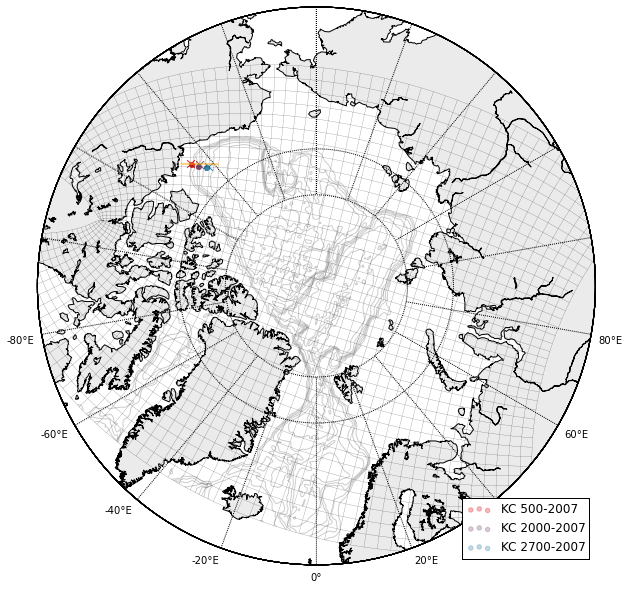

In [223]:
ax = plt.figure(1,figsize=(10,10))
ax = plt.subplot()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round='True')

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y=data['231 tot.'];
    lon = data['long.'];
    lat = data['lat.'];
    name= data['name'][0];

    lon=np.ma.masked_where(y<=0,lon)
    lat=np.ma.masked_where(y<=0,lat) 

    lon=lon.compressed()
    lat=lat.compressed()
    
    if len(lon)!=0:
        
        ax.hold(True)        
        y_lon, yy_lat = m(lon, lat)
        m.scatter(y_lon,yy_lat,color=cm.Set1(j*18),label=name,alpha=0.3)
    
    if j==0:
        m.drawcoastlines()
        m.fillcontinents(color = '0.85',alpha=0.5)
        m.drawparallels(np.arange(-90.,90.,15.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon, y_lat = m(nav_lon[:], nav_lat[:])
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon[::10,::10].T,y_lat[::10,::10].T,color='black',linewidth=0.2,alpha=0.7)
        m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.2)
        m.plot(x_lon[303,140:180],y_lat[303,140:180],lw=2,color='orange',alpha=0.5)
        m.scatter(x_lon[303,150],y_lat[303,150],color=cm.Set1(0*18),marker='x',s=60)
        m.scatter(x_lon[302,160],y_lat[302,160],color=cm.Set1(1*18),marker='x',s=60)
        m.scatter(x_lon[300,170],y_lat[300,170],color=cm.Set1(2*18),marker='x',s=60)
plt.legend(loc=4)
plt.show()

71.08 0.034721123
71.73 0.020134811
72.45 0.013322508


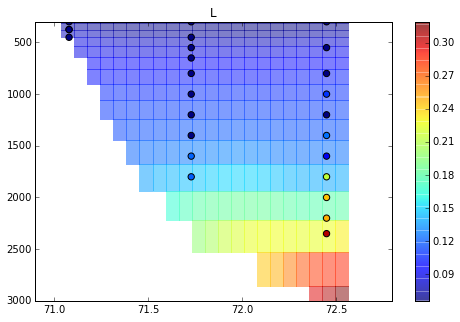

In [204]:
ax = plt.figure(1,figsize=(8,5))

lmin=25
lmax=46
data0=readdata('diss','Pa',i=0,a1=303,a2=304,b1=150,b2=175)\
    +readdata('part','Pa',i=0,a1=303,a2=304,b1=150,b2=175)
data_=data0[-1,lmin:lmax,0,:]
plt.pcolor(nav_lat[303,150:175],dep[lmin:lmax],data_,alpha=0.5)
plt.colorbar()

for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['231 tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    name= data['name'][0];
    
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    
    if len(lon_)!=0:
        print lat_[0],x_[0]
        plt.scatter(lat_,y_,c=x_,vmin=np.min(data_),vmax=np.max(data_),s=40)
plt.xlim([70.9,72.8]);plt.ylim([300,3000]);plt.gca().invert_yaxis();plt.title('%s'%(name[0]))
plt.show()

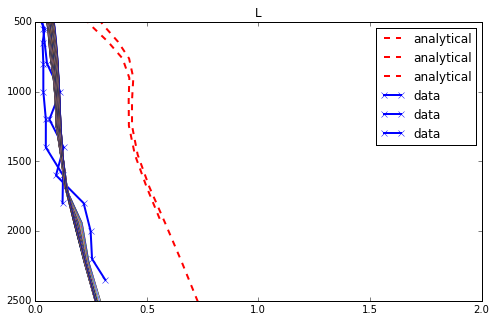

In [283]:
xloc=[303,302,300]
yloc=[150,160,170]

ax = plt.figure(1,figsize=(8,5))

for k in range (len(xloc)):   
    ice=readice('Th',i=0,x=xloc[k],y=yloc[k])
    ana=np.zeros(len(data0[0,:,0,0]))
    for z in range (len(data0[0,:,0,0])):
        ana[z]   =analy('Th','diss',i=z,a=xloc[k],b=yloc[k],ice=ice[-1,:])\
                 +analy('Th','part',i=z,a=xloc[k],b=yloc[k],ice=ice[-1,:])
    ana=np.ma.masked_where(np.ma.getmask(ice[-1,:]),ana)
    plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')


for j in range(len(nc_filename)):
    data=pd.read_csv(nc_filename[j])
    y= data['depth'].values;
    x=data['231 tot.'].values;
    lon = data['long.'].values;
    lat = data['lat.'].values;
    #name= data['name'][0];
    y_=[];x_=[];lon_=[];lat_=[];
    for i in range (len(x)):
        if x[i]>=0:
            y_.append(y[i]);x_.append(x[i])
            lon_.append(lon[i]);lat_.append(lat[i])
    if len(lon_)!=0:
        plt.plot(x_,y_,'-x',lw=2,c='blue',label='data')        

for i in range (len(data0[:,0,0,0])):
    plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5)#,label='simulation')

plt.ylim([500,2500])
plt.gca().invert_yaxis()
plt.title('%s'%(name[0]))
plt.legend()
plt.show()

## Next part: playing around with the parameters

>If the value of desorption rates are multiplied by 2,the line goes far away. If the **desorption** rates are **devided** by 2, the line is getting closer. However, this result is inconsistent with what we see on >the evalution, which wants its desorption rates to be bigger.

In [294]:
def plot_analytical(title):
    xloc=[303,302,300]
    yloc=[150,160,170]

    ax = plt.figure(1,figsize=(8,5))

    for k in range (len(xloc)):   
        ice=readice('Th',i=0,x=xloc[k],y=yloc[k])
        ana=np.zeros(len(data0[0,:,0,0]))
        for z in range (len(data0[0,:,0,0])):
            ana[z]   =analy('Th','diss',i=z,a=xloc[k],b=yloc[k],ice=ice[-1,:])\
                     +analy('Th','part',i=z,a=xloc[k],b=yloc[k],ice=ice[-1,:])
        ana=np.ma.masked_where(np.ma.getmask(ice[-1,:]),ana)
        plt.plot(ana,dep,'--',lw=2,c='red',label='analytical')


    for j in range(len(nc_filename)):
        data=pd.read_csv(nc_filename[j])
        y= data['depth'].values;
        x=data['231 tot.'].values;
        lon = data['long.'].values;
        lat = data['lat.'].values;
        #name= data['name'][0];
        y_=[];x_=[];lon_=[];lat_=[];
        for i in range (len(x)):
            if x[i]>=0:
                y_.append(y[i]);x_.append(x[i])
                lon_.append(lon[i]);lat_.append(lat[i])
        if len(lon_)!=0:
            plt.plot(x_,y_,'-x',lw=2,c='blue',label='data')        

    for i in range (len(data0[:,0,0,0])):
        plt.plot(data0[i,lmin:lmax,0,yloc[k]-150],dep[lmin:lmax],lw=0.5)#,label='simulation')

    plt.ylim([500,2500])
    plt.gca().invert_yaxis()
    plt.title('%s'%(title))
    plt.legend()
    plt.show()

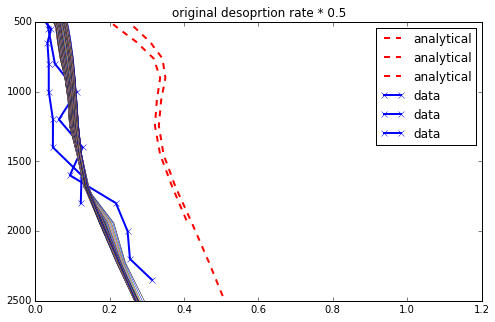

In [296]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=-0.0067*100*ice[i]+0.75
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)/2
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy

plot_analytical('original desoprtion rate * 0.5')

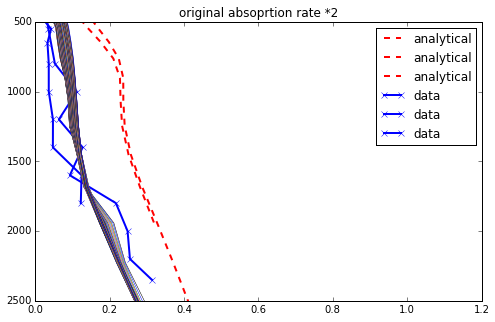

In [297]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=(-0.0067*100*ice[i]+0.75)*2
            if phase=='part':
                analy=0.0267/(2.26*100*ice[i]+500)*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/(2.26*100*ice[i]+500)*dep[i]
        
        return analy



plot_analytical('original absoprtion rate *2 ')

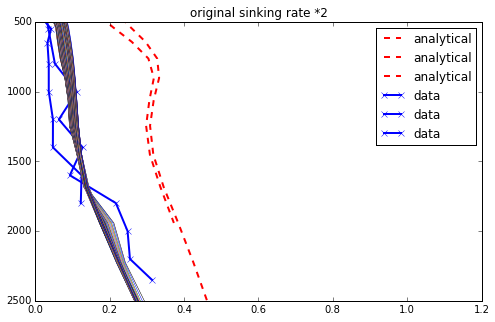

In [302]:
def analy(string,phase,i,a,b,ice):
        if string=='Th':
            k=(-0.0067*100*ice[i]+0.75)
            s=(2.26*100*ice[i]+500)*2
            if phase=='part':
                analy=0.0267/s*dep[i]
            else:
                k_1=readice('deso',i,a,b)
                analy=0.0267/k+k_1/k*0.0267/s*dep[i]
        
        return analy



plot_analytical('original sinking rate *2 ')

In [17]:
ice=readice('Th',i=0,x=303,y=150)
print ice[-12:,5]
ice=np.average(ice, axis=0)
print ice.shape
print (ice[4]*100)

[0.9902597069740295 0.9886507391929626 0.9799511432647705
 0.9743767976760864 0.9480538368225098 0.8937539458274841
 0.8382472991943359 0.6792030930519104 0.2014450877904892
 0.30932900309562683 0.9475971460342407 0.9652164578437805]
(50,)
84.1271281242
